In [25]:
from skopt import gp_minimize
from skopt import forest_minimize # Bayesian Optimization with RF as surrogate
from skopt import gbrt_minimize # Bayesian Optimization with GBM as surrogate
from skopt import Optimizer # for the optimization
from joblib import Parallel, delayed # for the parallelization
from skopt import dummy_minimize # for the randomized search
from skopt.plots import plot_convergence
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
cv = KFold(n_splits=5, shuffle=True, random_state=1)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math

In [28]:
PC  = pd.read_excel('deep_beam.xlsx',sheet_name='with')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp']]
y=PC['vn']
OUT_RANGE=(1,2)#important (better than (-1,1)) as I minimize the neg_mean_absolute_percentage_error
X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=OUT_RANGE)
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error


In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
import xgboost as xgb

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        "gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        #"num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("booster", ['gbtree', 'dart']),#, 'rf'
    }
    model = xgb.XGBRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-03-06 22:51:54,663] A new study created in memory with name: no-name-fab58dff-19ff-463f-8c09-15f9ca3be9ca
[I 2024-03-06 22:52:02,170] Trial 0 finished with value: 0.21500631626094324 and parameters: {'n_estimators': 106, 'learning_rate': 0.009621980920136908, 'gamma': 0.013231171797727032, 'max_depth': 8, 'booster': 'gbtree'}. Best is trial 0 with value: 0.21500631626094324.
[I 2024-03-06 22:52:02,998] Trial 5 finished with value: 0.10705109448992053 and parameters: {'n_estimators': 379, 'learning_rate': 0.006834344597004734, 'gamma': 23.701631888855967, 'max_depth': 44, 'booster': 'gbtree'}. Best is trial 5 with value: 0.10705109448992053.
[I 2024-03-06 22:52:03,121] Trial 4 finished with value: 0.05281191068508924 and parameters: {'n_estimators': 590, 'learning_rate': 0.030191120148063928, 'gamma': 0.15894195085329782, 'max_depth': 38, 'booster': 'gbtree'}. Best is trial 4 with value: 0.05281191068508924.
[I 2024-03-06 22:52:06,001] Trial 10 finished with value: 0.10838100829

Best hyperparameters: {'n_estimators': 54, 'learning_rate': 0.10294694379463112, 'gamma': 0.010194104841799619, 'max_depth': 34, 'booster': 'gbtree'}
Best RMSE: 0.032340523024423584


In [3]:
#'n_estimators': 54, 'learning_rate': 0.10294694379463112, 'gamma': 0.010194104841799619, 'max_depth': 34, 'booster': 'gbtree'
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
aa=xgb.XGBRegressor(n_estimators=54, max_depth=34, learning_rate=0.10294694379463112, booster='gbtree', gamma=0.010194104841799619)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)

df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'XGB_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)


MAPE 0.028979650028121216
MAPE 0.021036743532585635
MAPE 0.11815943013356647
Data exported to XGB_shear.xlsx


In [ ]:
MAPE 0.028509389615255645
MAPE 0.020794195060190666
MAPE 0.09404356968982433
Data exported to XGB_shear.xlsx

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from lightgbm.sklearn import LGBMRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.2, log=True),
        #"gamma": trial.suggest_float("gamma",0.01, 100, log=True),
        "max_depth": trial.suggest_int("max_depth", 16, 50),
        "num_leaves": trial.suggest_int("num_leaves", 10, 31),
        "boosting_type": trial.suggest_categorical("boosting_type", ['gbdt', 'dart']),#, 'rf'
    }
    model = LGBMRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

c:\Users\osama\anaconda3\lib\site-packages\dask\dataframe\_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(
[I 2024-03-06 23:06:37,186] A new study created in memory with name: no-name-f9456ca3-7343-4c35-b043-01a3b65d659c
[I 2024-03-06 23:06:53,047] Trial 2 finished with value: 0.39227862381655515 and parameters: {'n_estimators': 724, 'learning_rate': 0.003936685112097481, 'max_depth': 38, 'num_leaves': 14, 'boosting_type': 'dart'}. Best is trial 2 with value: 0.39227862381655515.
[I 2024-03-06 23:06:57,205] Trial 0 finished with value: 0.03265320110000184 and parameters: {'n_estimators': 1714, 'learning_rate': 0.04585881022735889, 'max_depth': 49, 'num_leaves': 22, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.03265320110000184.
[I 2024-03-06 23:07:10,660] Trial 3 finished with value: 0.03154073719480334 and parameters: {'n_estimators': 303, 'learning_rate': 0.0

Best hyperparameters: {'n_estimators': 637, 'learning_rate': 0.1600399958968201, 'max_depth': 35, 'num_leaves': 10, 'boosting_type': 'dart'}
Best RMSE: 0.02964593906984229


In [29]:
#{'n_estimators': 852, 'learning_rate': 0.0011233649860397813, 'max_depth': 25, 'num_leaves': 10, 'boosting_type': 'dart'}
#Best hyperparameters: {'n_estimators': 637, 'learning_rate': 0.1600399958968201, 'max_depth': 35, 'num_leaves': 10, 'boosting_type': 'dart'}
from lightgbm.sklearn import LGBMRegressor
aa=LGBMRegressor(n_estimators=637,learning_rate=0.1600399958968201, max_depth=35, num_leaves=10, boosting_type='dart')
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))

data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'LGBM_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 669
[LightGBM] [Info] Number of data points in the train set: 551, number of used features: 14
[LightGBM] [Info] Start training from score 1.273780
MAPE 0.02579459844346294
MAPE 0.015456546440602296
MAPE 0.07933470625309737
Data exported to LGBM_shear.xlsx


In [ ]:
MAPE 0.028509389615255645
MAPE 0.020794195060190666
MAPE 0.09404356968982433
Data exported to LGBM_shear.xlsx

In [8]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import optuna
from sklearn.ensemble import RandomForestRegressor

def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
        #"learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 50),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 50),
        "max_features": trial.suggest_categorical("max_features", ['sqrt','log2']),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),        
    }
    model = RandomForestRegressor(**params)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value 
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-03-06 23:41:30,381] A new study created in memory with name: no-name-77c41669-0915-44b5-818f-1e593558ad0c
[I 2024-03-06 23:41:32,410] Trial 0 finished with value: 0.09243457498332483 and parameters: {'n_estimators': 578, 'max_depth': 1, 'min_samples_leaf': 26, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 0.09243457498332483.
[I 2024-03-06 23:41:34,070] Trial 2 finished with value: 0.06129892012498175 and parameters: {'n_estimators': 129, 'max_depth': 10, 'min_samples_leaf': 18, 'max_features': 'log2', 'bootstrap': True}. Best is trial 2 with value: 0.06129892012498175.
[I 2024-03-06 23:41:36,587] Trial 3 finished with value: 0.06553523185062621 and parameters: {'n_estimators': 287, 'max_depth': 20, 'min_samples_leaf': 37, 'max_features': 'log2', 'bootstrap': False}. Best is trial 2 with value: 0.06129892012498175.
[I 2024-03-06 23:41:37,032] Trial 5 finished with value: 0.06688691206805845 and parameters: {'n_estimators': 965, 'max_depth': 32, 'min_sa

Best hyperparameters: {'n_estimators': 1245, 'max_depth': 26, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': False}
Best RMSE: 0.03679405130895174


In [6]:
from sklearn.ensemble import RandomForestRegressor
aa=RandomForestRegressor(random_state=1245,n_estimators=1245, max_depth=26, min_samples_leaf=2, max_features='log2', bootstrap=False)
print(np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1)
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'RF_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0.036169228248057884


c:\Users\osama\anaconda3\lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


MAPE 0.032887384625852716
MAPE 0.01863898785440939
MAPE 0.10591074447836606
Data exported to RF_shear.xlsx


In [5]:
import catboost as cb
import optuna
def objective(trial):
    params = {
        "iterations":trial.suggest_int("iterations", 100, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 16),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }

    model = cb.CatBoostRegressor(**params, silent=True)
    value = np.mean(cross_val_score(model, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))# optimization function (hyperparam response function)
    return -value

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=1000,n_jobs=-1)
print('Best hyperparameters:', study.best_params)
print('Best RMSE:', study.best_value)

[I 2024-03-07 00:53:39,260] A new study created in memory with name: no-name-581fdc90-8932-4606-b5be-c06d41b579a0
[I 2024-03-07 00:53:53,173] Trial 9 finished with value: 0.04528720322989847 and parameters: {'iterations': 373, 'learning_rate': 0.009386093010504352, 'depth': 6, 'subsample': 0.6354488298513594, 'colsample_bylevel': 0.5402367993495797, 'min_data_in_leaf': 76}. Best is trial 9 with value: 0.04528720322989847.
[I 2024-03-07 00:54:33,730] Trial 3 finished with value: 0.03739106549913368 and parameters: {'iterations': 773, 'learning_rate': 0.007889568891398456, 'depth': 11, 'subsample': 0.9148396665258716, 'colsample_bylevel': 0.29375510323145104, 'min_data_in_leaf': 5}. Best is trial 3 with value: 0.03739106549913368.
[I 2024-03-07 00:54:34,027] Trial 1 finished with value: 0.03539589779900722 and parameters: {'iterations': 1228, 'learning_rate': 0.0683368305334008, 'depth': 13, 'subsample': 0.1438528275086416, 'colsample_bylevel': 0.054060429487301026, 'min_data_in_leaf': 3

: 

In [8]:
#{'iterations': 1706, 'learning_rate': 0.055064666134721316, 'depth': 5, 'subsample': 0.7145542053408417, 'colsample_bylevel': 0.7134376025995272, 'min_data_in_leaf': 6}. Best is trial 425 with value: 0.02792233246641194.
#'iterations': 1169, 'learning_rate': 0.08157904502046057, 'depth': 5, 'subsample': 0.16684649915470987, 'colsample_bylevel': 0.6952707964024957, 'min_data_in_leaf': 21
import catboost as cb
aa=cb.CatBoostRegressor(iterations=1706,learning_rate=0.055064666134721316,depth=5,subsample=0.7145542053408417,colsample_bylevel=0.7134376025995272,min_data_in_leaf= 6)
#value = np.mean(cross_val_score(aa, X_train,y_train,cv=cv,n_jobs=-1,scoring='neg_mean_absolute_percentage_error'))*-1
aa.fit(X_train,y_train)
print('MAPE',mean_absolute_percentage_error(y_test, aa.predict(X_test)))

#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = aa.predict(X1_test)
print('MAPE',mean_absolute_percentage_error(y1_test, y1_pred))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
print('MAPE',mean_absolute_percentage_error(y1, data1))

data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000

filename = 'Cat_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

0:	learn: 0.1695183	total: 147ms	remaining: 4m 10s
1:	learn: 0.1648430	total: 148ms	remaining: 2m 6s
2:	learn: 0.1612228	total: 150ms	remaining: 1m 25s
3:	learn: 0.1575070	total: 151ms	remaining: 1m 4s
4:	learn: 0.1538119	total: 152ms	remaining: 51.6s
5:	learn: 0.1509157	total: 152ms	remaining: 43.2s
6:	learn: 0.1474572	total: 154ms	remaining: 37.3s
7:	learn: 0.1435441	total: 155ms	remaining: 32.8s
8:	learn: 0.1403918	total: 156ms	remaining: 29.3s
9:	learn: 0.1373150	total: 157ms	remaining: 26.6s
10:	learn: 0.1346277	total: 158ms	remaining: 24.3s
11:	learn: 0.1319179	total: 158ms	remaining: 22.4s
12:	learn: 0.1291754	total: 173ms	remaining: 22.5s
13:	learn: 0.1266792	total: 174ms	remaining: 21s
14:	learn: 0.1241445	total: 174ms	remaining: 19.7s
15:	learn: 0.1214573	total: 175ms	remaining: 18.5s
16:	learn: 0.1189794	total: 176ms	remaining: 17.5s
17:	learn: 0.1165376	total: 177ms	remaining: 16.6s
18:	learn: 0.1143994	total: 178ms	remaining: 15.8s
19:	learn: 0.1124017	total: 179ms	remaini

In [24]:
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from tabulate import tabulate

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam.xlsx',sheet_name='with')[['h','d','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp']]
y=PC['vn']

#PC['lam1']=PC['D']/PC['t']*PC['Fy']/208000.0

# Create a list to store the statistical properties for each feature
features = ['h','d','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','vn']
X1=PC[features]
correlation_matrix = X1.corr()
print(correlation_matrix)
data_stats = pd.DataFrame()

# Calculate statistical properties for each feature
data_stats['Min'] = PC[features].min()
data_stats['Max'] = PC[features].max()
data_stats['Mean'] = PC[features].mean()
data_stats['Std'] = PC[features].std()
data_stats['Skewness'] = PC[features].apply(skew)
data_stats['Kurtosis'] = PC[features].apply(kurtosis)

# Display the statistical properties
print(data_stats)


              h         d         b         a       a_d       fck       rho  \
h      1.000000  0.996975  0.252692  0.677219 -0.216594 -0.059027 -0.187461   
d      0.996975  1.000000  0.252008  0.671078 -0.227766 -0.069547 -0.230167   
b      0.252692  0.252008  1.000000  0.599580  0.422864  0.013399 -0.117385   
a      0.677219  0.671078  0.599580  1.000000  0.480302  0.032176 -0.055840   
a_d   -0.216594 -0.227766  0.422864  0.480302  1.000000  0.205667  0.246543   
fck   -0.059027 -0.069547  0.013399  0.032176  0.205667  1.000000  0.310707   
rho   -0.187461 -0.230167 -0.117385 -0.055840  0.246543  0.310707  1.000000   
fy     0.256985  0.257096  0.217876  0.173684 -0.100282  0.152056 -0.166842   
rho_v -0.070960 -0.074285 -0.229246 -0.146629 -0.125257  0.064194  0.126913   
fyv   -0.023529 -0.032687 -0.186002 -0.097431 -0.045876  0.228977  0.133766   
rho_h  0.054170  0.059755 -0.278947 -0.145100 -0.291046  0.016602 -0.105354   
fyh    0.143793  0.141584 -0.351698 -0.152440 -0.386

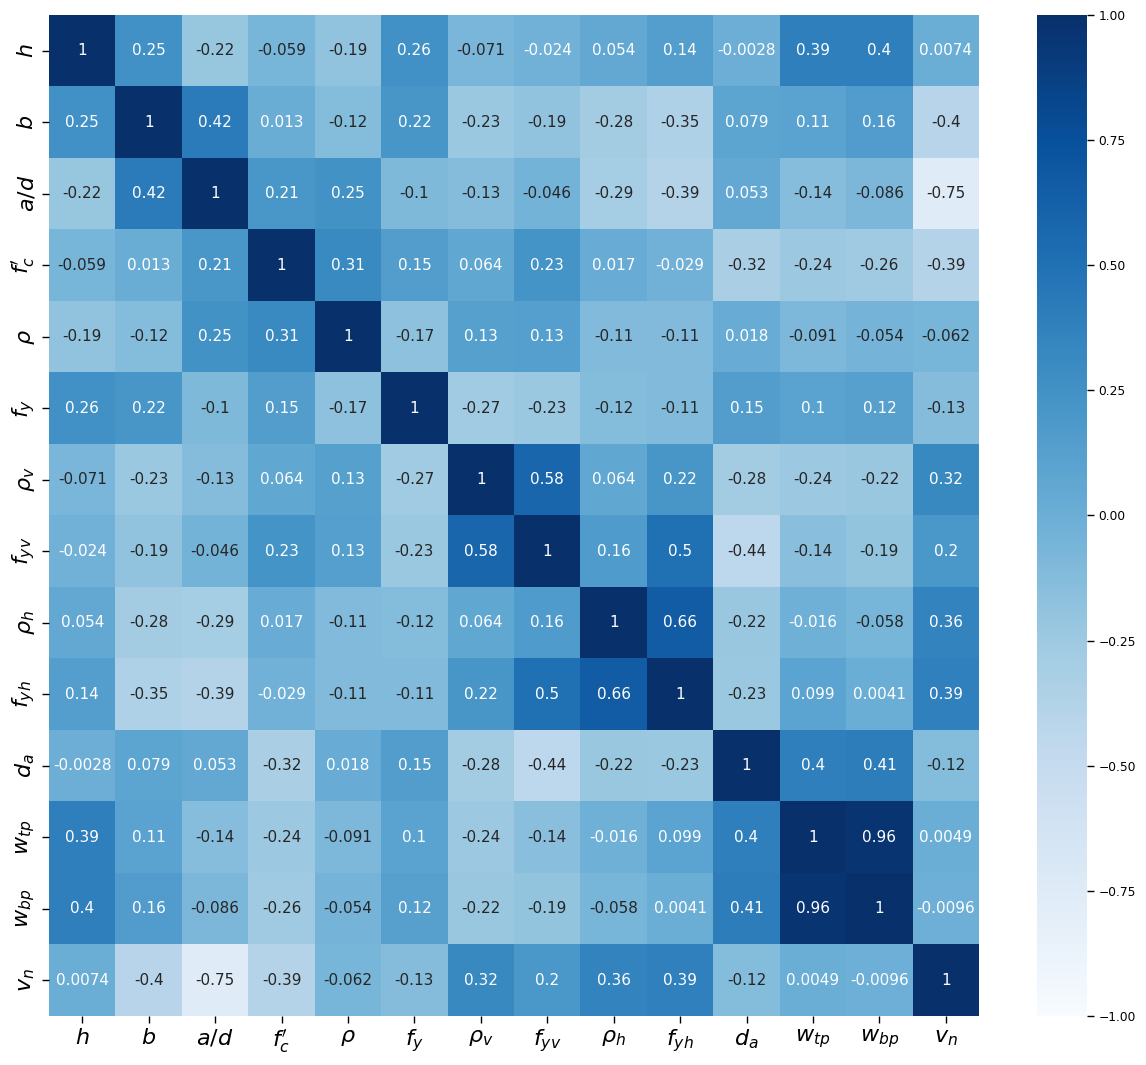

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Read the data from the Excel file
PC  = pd.read_excel('deep_beam.xlsx',sheet_name='with')[['h','b','a','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp']]
y=PC['vn']
features = ['h','b','a_d','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','vn']
X1=PC[features]

column_labels = ['$h$','$b$','$a/d$','$f^\\prime_c$', '$\\rho$', '$f_y$','$\\rho_v$', '$f_{yv}$','$\\rho_h$', '$f_{yh}$', '$d_a$','$w_{tp}$','$w_{bp}$', '$v_n$']#\\tilde{p}

# Calculate Pearson's correlation coefficient between features (X1)
correlation_matrix = X1.corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(15, 13),)
sns.heatmap(correlation_matrix, annot=True, cmap="Blues", vmin=-1, vmax=1, center=0)

sns.set_context("paper", rc={"font.size": 11, "axes.titlesize": 12, "axes.labelsize": 12})
plt.xticks(fontsize=16);plt.yticks(fontsize=16)
plt.xticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.yticks(ticks=np.arange(len(column_labels)) + 0.5, labels=column_labels)
plt.savefig("correlation_shear.png")

# Show the colorbar as a side bar

# Display the plot
plt.show()

SVR

In [11]:
import pso
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import math
pi = math.pi
PC  = pd.read_excel('deep_beam.xlsx',sheet_name='with')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp']]
y=PC['vn']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=42)
num_folds=5
def objective_function(params):
    C, epsilon, gamma = params
    mse_scores = []
    
    # Split the data into folds
    fold_size = len(X_train) // num_folds
    folds_X = np.array_split(X_train, num_folds)
    folds_y = np.array_split(y_train, num_folds)
    
    # Perform cross-validation
    for i in range(num_folds):
        # Create the SVR model
        model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
        
        # Merge the data for training and testing
        X_test_fold,X_train_fold = folds_X[i], np.concatenate(folds_X[:i] + folds_X[i+1:])
        y_test_fold,y_train_fold = folds_y[i], np.concatenate(folds_y[:i] + folds_y[i+1:])

        # Train the model and predict
        model.fit(X_train_fold, y_train_fold.reshape(-1))
        y_pred_fold = model.predict(X_test_fold)
        
        # Calculate the mean squared error
        divide = scaler_out.inverse_transform(y_pred_fold.reshape(-1, 1))/scaler_out.inverse_transform(y_test_fold.reshape(-1, 1))
        mse_fold = np.std(divide)
        
        mse_scores.append(mse_fold)
    
    # Calculate the mean of the mse scores
    mse = np.mean(mse_scores)
    return mse
lower_bound = [-3., -100.,-10.]
upper_bound = [5., -10., 20.]


# Define Optimization Problem
problem = {'CostFunction': objective_function, 'nVar': 3, 'VarMin': lower_bound, 'VarMax': upper_bound}

# Running PSO
gbest, pop = pso.PSO(problem, MaxIter = 10, PopSize = 100, c1 = 1.0, c2 = 1.0, w = 0.1, wdamp = 0.1)
# Final Result
print('Global Best:')
print(gbest)


Iteration 0: Best Cost = 0.2942860934623167
Iteration 1: Best Cost = 0.29308046886472955
Iteration 2: Best Cost = 0.29160862198836107
Iteration 3: Best Cost = 0.2902320044471593
Iteration 4: Best Cost = 0.2900792253611536
Iteration 5: Best Cost = 0.2899892590217422
Iteration 6: Best Cost = 0.2899423216552748
Iteration 7: Best Cost = 0.2899227082676828
Iteration 8: Best Cost = 0.2899222500529972
Iteration 9: Best Cost = 0.2899222500529972
Global Best:
{'position': array([  0.66431721, -60.9086163 ,  -1.76144035]), 'cost': 0.2899222500529972}


In [12]:
score = objective_function(gbest['position'])
print(gbest['cost'])
C, epsilon, gamma = gbest['position']#0.98377012, -69.37560749,   3.35051143
#increase number of particles from 50 to 500 #0.96109455, -27.71123196,   3.36205192
#[  0.95663944, -61.30657623,   3.36564107]), 'cost': 0.06111466489637234}
model = SVR(C=math.exp(C), epsilon=math.exp(epsilon), gamma=math.exp(gamma))
model.fit(X_train, y_train.reshape(-1))
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)
X1_test=np.concatenate((X_test, X_train), axis=0)
lengthy=len(y_train);print(lengthy)

y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = model.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
print(np.std(divide)/np.mean(divide))

X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)

df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'SVR_shear.xlsx'
df.to_excel(filename, index=False)

print("Data exported to", filename)


0.2899222500529972
0.02589237185827164
551
0.2321355432220737
Data exported to SVR_shear.xlsx


In [ ]:
Iteration 9: Best Cost = 0.24516452242183542
0.24516452242183542
0.01576801282445605
415
0.20100510176575626

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, WhiteKernel,RationalQuadratic,Matern
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import math
PC  = pd.read_excel('deep_beam.xlsx',sheet_name='with')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp']]
y=PC['vn']

X,y = np.array(X.values),np.array(y.values);scaler = MinMaxScaler(feature_range=(-1, 1));scaler_out = MinMaxScaler(feature_range=(-1, 1))
X_normalized=scaler.fit_transform(X);y_normalized=scaler_out.fit_transform(y.reshape(-1,1))
X_tot=X_normalized;y_tot=y_normalized
X_train, X_test, y_train, y_test = train_test_split(X_tot, y_tot, test_size=0.2, random_state=42)
'''
gpr = GaussianProcessRegressor(alpha=0.001)#,normalize_y=True
gpr.kernel = ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RBF(length_scale=1.0,length_scale_bounds=(1e-5,1e5))+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*Matern(length_scale=1.0, length_scale_bounds=(1e-5,1e5), nu=1.0)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*WhiteKernel(noise_level=0.1)+ConstantKernel(1.0,constant_value_bounds=(1e-5,1e5))*RationalQuadratic(length_scale=1,alpha=1)
gpr.fit(X_train, y_train.reshape(-1,1))'''

# Define the GPR model
gpr = GaussianProcessRegressor()
gpr.kernel = (
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RBF(length_scale=1.0, length_scale_bounds=(1e-5, 1e5)) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    Matern(length_scale=1.0, length_scale_bounds=(1e-5, 1e5), nu=1.0) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    WhiteKernel(noise_level=0.1) +
    ConstantKernel(1.0, constant_value_bounds=(1e-5, 1e5)) *
    RationalQuadratic(length_scale=1, alpha=1)
)

# Set up the parameter grid for alpha
alpha_values = [0.0001,0.0004,0.0005,0.0007,0.001,0.002,0.005,0.01]  # Add more values if needed

# Perform cross-validation to find the best alpha
best_alpha = None
best_score = -np.inf
for alpha in alpha_values:
    gpr.alpha = alpha
    scores = cross_val_score(gpr, X_train, y_train.reshape(-1, 1), cv=5)  # Use your desired number of folds
    mean_score = np.mean(scores)
    if mean_score > best_score:
        best_score = mean_score
        best_alpha = alpha


c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k1__constant_value is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\gaussian_process\ke

In [15]:
print(best_alpha)

0.0007


In [16]:
# Fit the GPR model with the best alpha
gpr.alpha = best_alpha
gpr.fit(X_train, y_train.reshape(-1, 1))

# Make predictions using the trained model
y_pred, y_std = gpr.predict(X_normalized, return_std=True)
if y_tot.ndim>1 and y_tot.shape[1]==1:y_tot=np.squeeze(y_tot,axis=1)
y_tot11=y_tot;y_std11=y_std;y_pred11=y_pred

In [17]:
#save data
X1_test=np.concatenate((X_test, X_train), axis=0);y1_test=np.concatenate((y_test, y_train), axis=0)
y1_pred = gpr.predict(X1_test)
divide=scaler_out.inverse_transform(y1_pred.reshape(-1, 1))/scaler_out.inverse_transform(y1_test.reshape(-1, 1))
X1=scaler.inverse_transform(X1_test);y1=scaler_out.inverse_transform(y1_test)
data=np.concatenate((X1,y1.reshape(-1, 1)),axis=1)
data1 = scaler_out.inverse_transform(y1_pred.reshape(-1, 1))
data2=np.concatenate((data,data1),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename = 'Gpr_shear.xlsx'
df.to_excel(filename, index=False)
print("Data exported to", filename)

Data exported to Gpr_shear.xlsx


In [22]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold,cross_val_score
from sklearn.model_selection._split import check_cv
from sklearn.base import is_classifier, clone
from joblib import Parallel
from sklearn.utils.fixes import delayed
from sklearn.utils.validation import _check_fit_params
from sklearn.utils.metaestimators import _safe_split
rand_stat=42
def cross_val_predict(estimator,X,y=None,*,groups=None,cv=None,n_jobs=None,verbose=0,
    fit_params=None,pre_dispatch="2*n_jobs",method="predict",XX):#XX  is added to crossfold

    cv = check_cv(cv, y, classifier=is_classifier(estimator))
    splits = list(cv.split(X, y, groups))
    test_indices = np.concatenate([test for _, test in splits])    
    parallel = Parallel(n_jobs=n_jobs, verbose=verbose, pre_dispatch=pre_dispatch)
    ppp = parallel(
        delayed(_fit_and_predict)(clone(estimator), X, y, train, test, verbose, fit_params, method,XX=XX)
        for train, test in splits)
    
    inv_test_indices = np.empty(len(test_indices), dtype=int)
    inv_test_indices[test_indices] = np.arange(len(test_indices))
    predictions=[];y_pred_tot=[]
    for i in range(len(ppp)):
        predictions.append(ppp[i][0])
        y_pred_tot.append(ppp[i][1])                    #this line is added to crossfold
    pred = np.concatenate(predictions)
    return pred[inv_test_indices],y_pred_tot            #y_pred_tot is added to crossfold
def _fit_and_predict(estimator, X, y, train, test, verbose, fit_params, method,XX):#XX  is added to crossfold
    fit_params = fit_params if fit_params is not None else {}
    fit_params = _check_fit_params(X, fit_params, train)

    X_train, y_train = _safe_split(estimator, X, y, train)
    X_test, _ = _safe_split(estimator, X, y, test, train)

    estimator.fit(X_train, y_train, **fit_params)
    func = getattr(estimator, method)
    predictions = func(X_test)
    p_red = func(XX)                                    #this line is added to crossfold
    return predictions,p_red
nfoldy=5
feature_range=(0,7)
PC  = pd.read_excel('deep_beam.xlsx',sheet_name='with')[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V']]
PC['vn']=PC['V']/(PC['h'] * PC['b'])/PC['fck']*1000
X=PC[['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp']]
y=PC['vn']
X,y = np.array(X.values),np.array(y.values)
scaler = MinMaxScaler(feature_range=(-1, 1));output_scaler = MinMaxScaler(feature_range=feature_range)
X_normalized = scaler.fit_transform(X);y_normalized = output_scaler.fit_transform(y.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_normalized, test_size=0.2, random_state=rand_stat)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X,y, test_size=0.2, random_state=rand_stat)

X_normalized=np.concatenate((X_test, X_train), axis=0);X=np.concatenate((X_test1, X_train1), axis=0);y=np.concatenate((y_test1, y_train1), axis=0)
model = MLPRegressor(hidden_layer_sizes=5, activation='logistic',max_iter=100000, solver='lbfgs', random_state=42)
kfold = KFold(n_splits=nfoldy, shuffle=True, random_state=42)
y_pred_train,p_red = cross_val_predict(model, X_train, y_train.ravel(), cv=kfold,XX=X_normalized)
y_pred_train = output_scaler.inverse_transform(y_pred_train.reshape(-1, 1))
rr=y_normalized*0.0
for i in range(nfoldy):#not found in normal fold
    rr+=np.array(p_red[i]).reshape(-1, 1)/nfoldy
y_pred_tot = output_scaler.inverse_transform(rr)


#visulaization
data1=np.concatenate((X,y.reshape(-1, 1)),axis=1)
data2=np.concatenate((data1,y_pred_tot[:,-1].reshape(-1, 1)),axis=1)
df = pd.DataFrame(data2)
df.columns = ['h','d','b','a','fck','rho','fy','rho_v','fyv','rho_h','fyh','da','w_tp','w_bp','V_exp','V_pred'];PC=df
PC['V_exp']=PC['V_exp']*(PC['h'] * PC['b'])*PC['fck']/1000
PC['V_pred']=PC['V_pred']*(PC['h'] * PC['b'])*PC['fck']/1000
filename ='ML_shear.xlsx'
df.to_excel(filename, index=False)

print(np.std(data2[:,-2]/data2[:,-1]),np.mean(data2[:,-2]/data2[:,-1])) #0.06421353092185479 0.9994000056676541

c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
c:\Users\osama\anaconda3\lib\site-packages\sklearn\utils\parallel.py:116: UserWarning: `sklear

0.22415566134003787 1.005745263371829
